In [21]:
import os
import numpy as np
import scipy
import datetime, time
import gc
import random

from multiprocessing import Pool
from functools import partial

from matplotlib import pyplot as plt

initial image


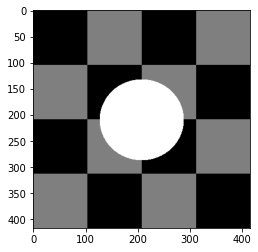

In [2]:
path = '../../../test1.bmp'
arr = plt.imread(path)[...,0]
labels = np.array(arr / 127, dtype=int)
x_arr = arr / 255.
print ("initial image")
plt.imshow(x_arr, cmap='gray');

In [3]:
def add_noise(x, sigma):
    noise = np.random.normal(0, sigma, x.shape)
    return x + noise

In [4]:
def pdf_of_normal(x, mean, var):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))

${\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}}$

In [5]:
def gaussian_log_density(x, mean, log_var):
    """Computes the log density of a Gaussian."""
    log2pi = np.log(2. * np.pi)
    inv_sigma = np.exp(-log_var)
    delta = (x - mean)
    return - 0.5 * (delta**2 * inv_sigma + log_var + log2pi)

def gaussian_density(x, mean, var):
    """Computes the density of a Gaussian."""
    norm_const = 1. / np.sqrt(2 * np.pi + 1e-7)
    inv_sigma = 1. / np.sqrt(var + 1e-7)
    delta_sq = (x - mean)**2
    return norm_const * inv_sigma * np.exp(-delta_sq / (2 * var + 1e-7))

In [6]:
label_to_value = {
    0: 0,
    1: 127,
    2: 255
}
value_to_label = {v: k for k, v in label_to_value.items()}

In [7]:
def get_dims(x):
    """Returns the (b)atch, (h)eight, (w)idth, and (d)epth of an array/tensor."""
    ndim = len(x.shape) # in the case of a tensor
    if ndim == 2:
        return (0, *x.shape, 0)
    elif ndim == 4:
        return x.shape
    else:
        raise ValueError(f"Expected 2 or 4 dims, got {x.ndim}")

In [8]:
def naive_bayes_learning(arr, noisy_arr, labels):
    class_info = []
    number_of_pixels = arr.size
    for cls in [0,1,2]:
        tmp = []
        for i in range(0, len(arr)):
            for j in range(0, len(arr[0])):
                if (labels[i][j]==cls):
                    tmp.append(noisy_arr[i][j])
        tmp = np.asarray(tmp)
        class_mean = np.mean(tmp)
        class_var = np.var(tmp)
        class_freq = len(tmp)
        class_probabilty = class_freq/number_of_pixels
        class_info.append([class_probabilty, class_mean, class_var])
    return class_info

def pdf_of_normal(x, mean, var):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))

def naive_bayes_predict (arr, class_info, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            val = arr[i][j]
            for cls_index in range(len(class_info)):
                cls_p =  class_info[cls_index][0]
                mean =  class_info[cls_index][1]
                var = class_info[cls_index][2]
                pos =pdf_of_normal(val, mean, var)
                cls_posterior = cls_p * pos

                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index
            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

In [9]:
var_list = [1.,]
for var in var_list:
    x_noise = add_noise(x_arr, var)
    cls_info = naive_bayes_learning(x_arr, x_noise, labels)
    prediciton_array = naive_bayes_predict(x_noise, cls_info)
    print ("Noisy Image with var", var)
    plt.imshow(x_noise, cmap='gray')
    plt.show()
    print ("Naive Bayes Classifier Labels")
    plt.imshow(prediciton_array, cmap='gray')
    plt.show()
    break

In [10]:
def distance (x,y):
    a = x-y
    a = a*a
    return np.sqrt(np.sum(a))

def differnce(a,b):
    if (a==b):
        return -1
    else:
        return 1
    
def initial_energy_function(initial_w, pixels, betha, cls_info, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            mean = cls_info[int (w[i][j])][1]
            var =  cls_info[int (w[i][j])][2]
            energy += np.log(np.sqrt(2*np.pi*var)) 
            energy += ((pixels[i][j]-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * differnce(w[i][j], w[a][b])
    return energy

In [11]:
def exponential_schedule(step_number, current_t, initial_temp,  constant=0.99):
    return current_t*constant

def logarithmical_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * np.log(1+step_number))

def linear_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * step_number)

def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var =  cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * differnce(w[i][j], w[a][b])
    
    new_energy = 0
    mean = cls_info[new_value][1]
    var =  cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
    # print("/////// \n first enegry", new_energy)

    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * differnce(new_value, w[a][b])

    # print ("END energy", new_energy)
    return new_energy - initial_energy

In [12]:
def compute_energy(x, mu, var):
    return np.log(np.sqrt(2. * np.pi * var)) + ((x - mu)**2 / (2. * var))

In [26]:
DEFAULT_NEIGHBORS = np.array([
    [0,  1., 0 ],
    [1., 0,  1.],
    [0,  1., 0 ]
])

def default_rule(x):
    rule = {True: -1, False: 1}
    return rule.get(x)

def default_rule(x):
    return -1 if x == True else 1


class NaiveBayes:
    
    def __init__(self, num_classes, priors=None):
        self.num_classes = num_classes
        self.params = {}
        # should these mean of each feature per class tho?
        # i.e. mean of each object per symbol/color???
        self.mu = np.zeros(self.num_classes, np.float64)
        self.sigma = np.zeros(self.num_classes, np.float64)
        self.freq = np.zeros(self.num_classes, np.int64)
        self.priors = np.zeros(self.num_classes, np.float64)
        
        self._class_mu = None
        self._class_sigma = None
        
        self.hist = {
            'mu': [],
            'sigma': [],
            'freq': [],
            'priors': []
        }
        
    def fit(self, X, y):
        self._compute_priors(X, y)
        return self
    
    def _compute_priors(self, X, y):
        size = X.size
        for c in range(self.num_classes):
            X_class = X[np.where(y == c)]
            self.mu[c] = np.mean(X_class)
            self.sigma[c] = np.var(X_class)
            self.freq[c] = len(X_class)
            self.priors[c] = self.freq[c] / size
        
        self._update_params_hist()
       
    def _update_params_hist(self):
        self.params = {
            'mu': self.mu,
            'sigma': self.sigma,
            'freq': self.freq,
            'priors': self.priors
        }
        
        self.hist['mu'].append(self.mu.tolist())
        self.hist['sigma'].append(self.sigma.tolist())
        self.hist['freq'].append(self.freq.tolist())
        self.hist['priors'].append(self.priors.tolist())
        
        self._class_mu = {i: v for i, v in enumerate(self.mu)}
        self._class_sigma = {i: v for i, v in enumerate(self.sigma)}
        
    def _update_priors(self, X, y):
        classes = np.unique(y)
        for index in classes:
            X_class = X[np.where(y == index)]
            n_prev = self.freq[index]
            n_new = len(X_class)
            n_total = n_prev + n_new

            mu_prev = self.mu[index]
            mu_new = np.mean(X_class)

            mu_updated = (n_prev * mu_prev + n_new * mu_new) / n_total

            ssd_prev = n_prev * self.sigma[index]
            ssd_new = n_new * np.var(X)
            delta = mu_prev - mu_new
            ssd_total = (ssd_prev + ssd_new + (n_new * n_prev / n_total) * (delta)**2)
            sigma_updated = ssd_total / n_total

            self.mu[index] = mu_updated
            self.sigma[index] = sigma_updated
            self.freq[index] = n_total
        
        for index in classes:
            self.priors[index] = self.freq[index] / sum(self.freq)

        self._update_params_hist()
    
    def _log_likelihoods(self, X):
        lls = []
        for c in range(self.num_classes):
            px_cond_c = gaussian_density(X, self.mu[c], self.sigma[c])
            pc_cond_x = self.priors[c] * px_cond_c
            lls.append(pc_cond_x)
        return lls
        
    def predict(self, X):
        return np.argmax(self._log_likelihoods(X), axis=0)


class MRF(NaiveBayes):
    """
    
    https://www2.isye.gatech.edu/~brani/isyebayes/bank/handout16.pdf
    Gibbs
    -----
        P(X) = 1/Z * exp( U(X)/T )
    
    Z is a normalizing constant called the partition function, 
    T is a constant called the temperature 
    U is the energy function. The energy U(X) = sum_c( V(X) )
        is a sum of clique potentials V_c over all possible cliques c ∈ C.
        The value of depends on the local configuration on the clique c. 
    """
    
    def __init__(self, 
                 num_classes,
                 scheduler=None,
                 beta=100,
                 start_temperature=1000,
                 temperature_factor=0.99,
                 neighbors=None,
                 delta_rule=None,
                 delta_th=10,
                 workers=None,
                 verbose=0):
        super(MRF, self).__init__(num_classes)
        self.scheduler = scheduler
        self.beta = beta
        self.start_temperature = start_temperature
        self.temperature_factor = temperature_factor
        if delta_rule is None:
            self.delta_rule = default_rule
        else:
            self.delta_rule = delta_rule
        if neighbors is None:
            self.neighbors = DEFAULT_NEIGHBORS
        else:
            self.neighbors = neighbors
        self.delta_th = delta_th
        self.workers = workers
        self.verbose = verbose
        
        self.nh_, self.nw_ = self.neighbors.shape
        if self.nh_ % 2 == 0 or self.nw_ % 2 == 0:
            raise ValueError('Expected `neighbors` to have odd dimensions, '
                             f'got {(nh, nw)}')
        self.nh_pad = self.nh_ // 2
        self.nw_pad = self.nw_ // 2
            
        self._classes = list(range(self.num_classes))
        self._neighbor_indices = list(zip(*np.where(self.neighbors > 0)))
        self._workers = 0 if self.workers is None else self.workers
        self._verbose = self.verbose if self.verbose > 0 else np.inf

    def fit(self, X, y, num_steps=100, max_iterations=1000):
        b, h, w, d = get_dims(X)
        self._compute_priors(X, y)
        X_prior = np.argmax(self._log_likelihoods(X), axis=0)
        for step in range(num_steps):
            print(step)
            X_prior, X_changed = self.fit_partial(X, X_prior, y, max_iterations)
        return X_prior, X_changed
    
    def fit_partial(self, X, X_prior, y, max_iterations):
        X_prior, X_changed = self._simiulated_annealing(X, X_prior, max_iterations, y)
#         self._update_priors(X_prior, y)
        self._compute_priors(X_prior, y)
        X_prior = np.argmax(self._log_likelihoods(X_prior), axis=0)
        return X_prior, X_changed
    
    def _sample_false_positive(self, c):
        # faster than numpy solutions
        fps = list(self._classes)
        fps.remove(c)
        return fps[random.randint(0, self.num_classes-2)]
    
    def predict(self, X):
        pass
    
    def _delta_energy(self, X, X_prior, index, new_class):
        i, j = index
        nh = X.shape[0] - self.nh_ 
        nw = X.shape[1] - self.nw_ 
        current_class = X_prior[index]
        
        current_energy = compute_energy(X[index], self.mu[current_class], self.sigma[current_class])
        new_energy = compute_energy(X[index], self.mu[new_class], self.sigma[new_class])
        
        # update energy together
        for ni, nj in self._neighbor_indices:
            ni_ix = ni + i
            nj_ix = nj + j
            if 0 <= ni_ix < nh and 0 <= nj_ix < nw:
                current_energy += (self.delta_rule(X_prior[ni_ix, nj_ix] == current_class))# * self.neighbors[ni, nj])
                new_energy += (self.delta_rule(X_prior[ni_ix, nj_ix] == new_class))# * self.neighbors[ni, nj])

        return new_energy - current_energy
    
    def _nbh_energy(self, index, X, value=None):
        b, h, w, d = get_dims(X)
        nh = h - self.nh_
        nw = w - self.nw_
        i, j = index
        v = value if value is not None else X[i, j]
        energy = 0.
        
        # surprisingly faster than vectorizing
        for ni, nj in self._neighbor_indices:
            ni_ix = ni + i
            nj_ix = nj + j
            if 0 <= ni_ix < nh and 0 <= nj_ix < nw:
                energy += (self.delta_rule(X[ni_ix, nj_ix] == v) * self.neighbors[ni, nj])
                
        return self.beta * energy
        
    def _total_energy(self, X, X_prior):
        b, h, w, d = get_dims(X)
        
        # matrices of mean and variance in place of classes
        X_mean = np.vectorize(self._class_mu.__getitem__)(X_prior)
        X_var = np.vectorize(self._class_sigma.__getitem__)(X_prior)
        energy = np.sum(compute_energy(X, X_mean, X_var))
        
        # accumulate energy using the delta rule of each values neighbors
        if self._workers > 0:
            f = partial(self._nbh_energy, X=X_prior)
            with Pool(self.workers) as p:
                nbh_energy = p.map(f, [(i,j) for i in range(h) for j in range(w)])
            gc.collect()
        else:
            nbh_energy = [
                self._nbh_energy((i,j), X_prior) for i in range(h) for j in range(w)
            ]
            
        return energy + np.sum(nbh_energy)
    
    def _simiulated_annealing(self, X, X_prior, num_steps, y=None):
        b, h, w, d = get_dims(X)
        
        energy = self._total_energy(X, X_prior)
        x_changed = np.zeros((h, w))
        temperature = self.start_temperature
        self.deltas = []
        self.idx = []
        self.new_classes = []
        self.energy = [energy]
        self.changed = []
        
        start_dt = time.time()
        for step in range(1, num_steps+1):
            if step % self._verbose == 0:
                elapsed_time = time.time() - start_dt
                template = f'step {step} - {int(elapsed_time)}s '
                template += f'{int(elapsed_time/step)}s/step - energy : {energy:.4f} '
                if y is not None:
                    template += f'- acc : {np.mean(X_prior == y):.4f}'
                print(template)
            
            i = random.randint(0,h-1)
            j = random.randint(0,w-1)
            
            new_class = self._sample_false_positive(X_prior[i,j])
            delta = self._delta_energy(X, X_prior, (i,j), new_class)
            self.idx.append((i,j))
            self.new_classes.append(new_class)
            self.deltas.append(delta)

            if delta <= 0:
                X_prior[i,j] = new_class
                energy += delta
                x_changed[i, j] += 1
                self.changed.append(1)
            else:
                # where did this come from / come back to this
                if delta / temperature > self.delta_th:
                    # don't update
                    k = 0
                else:
                    # change probabilistically
                    k = np.exp(-delta / temperature)

                if np.random.uniform(0, 1) < k:
                    X_prior[i,j] = new_class
                    energy += delta
                    x_changed[i,j] += 1
                    self.changed.append(1)
                else:
                    self.changed.append(0)

            self.energy.append(energy)
            if self.scheduler is not None:
                temperature = self.scheduler(step, 
                                             temperature, 
                                             self.start_temperature, 
                                             self.temperature_factor)
        return X_prior, x_changed

0
step 10000 - 0s 0s/step - energy : -204145.7017 - acc : 0.5347
step 20000 - 0s 0s/step - energy : -210394.6780 - acc : 0.5361
step 30000 - 1s 0s/step - energy : -216517.5443 - acc : 0.5383
step 40000 - 1s 0s/step - energy : -222463.6739 - acc : 0.5400
step 50000 - 1s 0s/step - energy : -228358.9243 - acc : 0.5416
step 60000 - 2s 0s/step - energy : -234238.0817 - acc : 0.5435
step 70000 - 2s 0s/step - energy : -239397.4033 - acc : 0.5450


/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:283: RuntimeWarning: overflow encountered in double_scalars


step 80000 - 3s 0s/step - energy : -244702.4444 - acc : 0.5470
step 90000 - 3s 0s/step - energy : -250131.2406 - acc : 0.5489
step 100000 - 3s 0s/step - energy : -255365.5215 - acc : 0.5507
1
step 10000 - 0s 0s/step - energy : -761735.2002 - acc : 0.5545
step 20000 - 0s 0s/step - energy : -766385.4980 - acc : 0.5565
step 30000 - 1s 0s/step - energy : -770996.8452 - acc : 0.5585
step 40000 - 1s 0s/step - energy : -775677.5952 - acc : 0.5602
step 50000 - 1s 0s/step - energy : -780285.6382 - acc : 0.5622
step 60000 - 2s 0s/step - energy : -784893.4364 - acc : 0.5646
step 70000 - 2s 0s/step - energy : -789373.3644 - acc : 0.5666
step 80000 - 3s 0s/step - energy : -793693.9893 - acc : 0.5686
step 90000 - 3s 0s/step - energy : -798000.6616 - acc : 0.5705
step 100000 - 4s 0s/step - energy : -802310.3709 - acc : 0.5726
2
step 10000 - 0s 0s/step - energy : -1295843.7428 - acc : 0.5758
step 20000 - 0s 0s/step - energy : -1300053.3972 - acc : 0.5777
step 30000 - 1s 0s/step - energy : -1304048.411

step 60000 - 2s 0s/step - energy : -4242773.3636 - acc : 0.7143
step 70000 - 2s 0s/step - energy : -4243998.2846 - acc : 0.7148
step 80000 - 3s 0s/step - energy : -4245333.3736 - acc : 0.7151
step 90000 - 3s 0s/step - energy : -4246683.2552 - acc : 0.7156
step 100000 - 4s 0s/step - energy : -4247805.4043 - acc : 0.7159
14
step 10000 - 0s 0s/step - energy : -4323361.6284 - acc : 0.7171
step 20000 - 0s 0s/step - energy : -4324597.0431 - acc : 0.7177
step 30000 - 1s 0s/step - energy : -4325790.4924 - acc : 0.7180
step 40000 - 1s 0s/step - energy : -4326936.3654 - acc : 0.7183
step 50000 - 1s 0s/step - energy : -4328128.1374 - acc : 0.7188
step 60000 - 2s 0s/step - energy : -4329200.6217 - acc : 0.7191
step 70000 - 2s 0s/step - energy : -4330388.5303 - acc : 0.7197
step 80000 - 3s 0s/step - energy : -4331429.8388 - acc : 0.7200
step 90000 - 3s 0s/step - energy : -4332516.5573 - acc : 0.7202
step 100000 - 4s 0s/step - energy : -4333760.8112 - acc : 0.7207
15
step 10000 - 0s 0s/step - energy

step 40000 - 1s 0s/step - energy : -4689495.5152 - acc : 0.7408
step 50000 - 2s 0s/step - energy : -4689854.1750 - acc : 0.7408
step 60000 - 2s 0s/step - energy : -4690199.6468 - acc : 0.7408
step 70000 - 2s 0s/step - energy : -4690615.5711 - acc : 0.7407
step 80000 - 3s 0s/step - energy : -4690935.9981 - acc : 0.7408
step 90000 - 3s 0s/step - energy : -4691276.5810 - acc : 0.7408
step 100000 - 4s 0s/step - energy : -4691616.7860 - acc : 0.7408
27
step 10000 - 0s 0s/step - energy : -4698915.7966 - acc : 0.7411
step 20000 - 0s 0s/step - energy : -4699241.9903 - acc : 0.7411
step 30000 - 1s 0s/step - energy : -4699606.0045 - acc : 0.7410
step 40000 - 1s 0s/step - energy : -4699986.5250 - acc : 0.7411
step 50000 - 1s 0s/step - energy : -4700372.1459 - acc : 0.7411
step 60000 - 2s 0s/step - energy : -4700736.3709 - acc : 0.7410
step 70000 - 2s 0s/step - energy : -4701021.1281 - acc : 0.7410
step 80000 - 3s 0s/step - energy : -4701312.6096 - acc : 0.7409
step 90000 - 3s 0s/step - energy : -

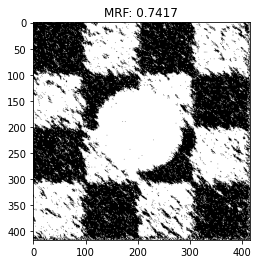

In [27]:
# x_noise = add_noise(x_arr, 1.)
model3 = MRF(3, 
             beta=10,
             start_temperature=1., 
             verbose=10000,
             delta_th=.5,
             scheduler=exponential_schedule,
             workers=8)
start_dt = time.time()
a,b = model3.fit(x_noise, labels, num_steps=30, max_iterations=100000)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')

y_pred = np.vectorize(label_to_value.__getitem__)(a) 

plt.imshow(y_pred/255., 'gray')
plt.title(f'MRF: {np.mean(y_pred == arr):.4f}')
plt.show();

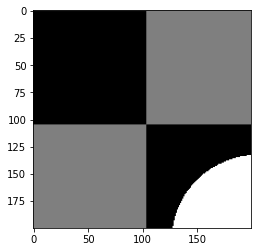

In [34]:
plt.imshow(x_arr[:200,:200], 'gray')

In [ ]:
'Mutual Information Neural Estimation'.

In [30]:
'Mutual Information Neural Estimation'.replace(' ', '_')

'Mutual_Information_Neural_Estimation'

step 10000 - 0s 0s/step - energy : -204246.2833 - acc : 0.5343
step 20000 - 0s 0s/step - energy : -210473.3218 - acc : 0.5358
step 30000 - 1s 0s/step - energy : -216761.6484 - acc : 0.5380
step 40000 - 1s 0s/step - energy : -222652.4846 - acc : 0.5398
step 50000 - 1s 0s/step - energy : -228664.2514 - acc : 0.5415
step 60000 - 2s 0s/step - energy : -234373.0745 - acc : 0.5432
step 70000 - 2s 0s/step - energy : -240107.8676 - acc : 0.5449


/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:282: RuntimeWarning: overflow encountered in double_scalars


step 80000 - 3s 0s/step - energy : -245528.9604 - acc : 0.5469
step 90000 - 3s 0s/step - energy : -250985.8229 - acc : 0.5488
step 100000 - 4s 0s/step - energy : -256041.3587 - acc : 0.5503
step 10000 - 0s 0s/step - energy : -911234.8298 - acc : 0.5536
step 20000 - 0s 0s/step - energy : -916105.0537 - acc : 0.5555
step 30000 - 1s 0s/step - energy : -921315.6183 - acc : 0.5576
step 40000 - 1s 0s/step - energy : -926187.6196 - acc : 0.5593
step 50000 - 1s 0s/step - energy : -931317.6626 - acc : 0.5611
step 60000 - 2s 0s/step - energy : -936051.5572 - acc : 0.5632
step 70000 - 2s 0s/step - energy : -940873.1818 - acc : 0.5654
step 80000 - 3s 0s/step - energy : -945757.9487 - acc : 0.5677
step 90000 - 3s 0s/step - energy : -950614.0950 - acc : 0.5699
step 100000 - 4s 0s/step - energy : -955173.6718 - acc : 0.5718
step 10000 - 0s 0s/step - energy : -1452399.9089 - acc : 0.5753
step 20000 - 0s 0s/step - energy : -1456914.6075 - acc : 0.5773
step 30000 - 1s 0s/step - energy : -1461303.3419 - 

step 70000 - 2s 0s/step - energy : -4683411.6353 - acc : 0.7164
step 80000 - 3s 0s/step - energy : -4684917.5232 - acc : 0.7167
step 90000 - 3s 0s/step - energy : -4686626.5233 - acc : 0.7172
step 100000 - 4s 0s/step - energy : -4688097.9994 - acc : 0.7176
step 10000 - 0s 0s/step - energy : -4818240.5778 - acc : 0.7193
step 20000 - 0s 0s/step - energy : -4819613.8838 - acc : 0.7196
step 30000 - 1s 0s/step - energy : -4820958.5841 - acc : 0.7198
step 40000 - 1s 0s/step - energy : -4822329.1310 - acc : 0.7201
step 50000 - 2s 0s/step - energy : -4823583.8790 - acc : 0.7204
step 60000 - 2s 0s/step - energy : -4825023.1745 - acc : 0.7206
step 70000 - 2s 0s/step - energy : -4826364.2570 - acc : 0.7209
step 80000 - 3s 0s/step - energy : -4827652.8080 - acc : 0.7210
step 90000 - 3s 0s/step - energy : -4828967.9317 - acc : 0.7212
step 100000 - 4s 0s/step - energy : -4830209.3924 - acc : 0.7214
step 10000 - 0s 0s/step - energy : -4923390.0062 - acc : 0.7231
step 20000 - 0s 0s/step - energy : -49

step 50000 - 1s 0s/step - energy : -5597291.7835 - acc : 0.7358
step 60000 - 2s 0s/step - energy : -5597898.4728 - acc : 0.7357
step 70000 - 2s 0s/step - energy : -5598644.7188 - acc : 0.7355
step 80000 - 3s 0s/step - energy : -5599253.7131 - acc : 0.7354
step 90000 - 3s 0s/step - energy : -5599898.0203 - acc : 0.7353
step 100000 - 4s 0s/step - energy : -5600477.6639 - acc : 0.7350
step 10000 - 0s 0s/step - energy : -5626912.5855 - acc : 0.7359
step 20000 - 0s 0s/step - energy : -5627417.6092 - acc : 0.7357
step 30000 - 1s 0s/step - energy : -5628105.8224 - acc : 0.7355
step 40000 - 1s 0s/step - energy : -5628863.6712 - acc : 0.7353
step 50000 - 1s 0s/step - energy : -5629591.0590 - acc : 0.7351
step 60000 - 2s 0s/step - energy : -5630182.5287 - acc : 0.7349
step 70000 - 2s 0s/step - energy : -5630691.4312 - acc : 0.7346
step 80000 - 3s 0s/step - energy : -5631286.8290 - acc : 0.7343
step 90000 - 3s 0s/step - energy : -5631964.9657 - acc : 0.7342
step 100000 - 4s 0s/step - energy : -56

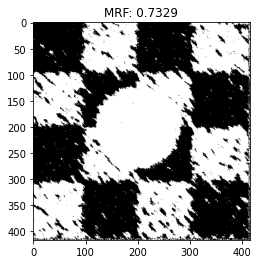

In [24]:
# x_noise = add_noise(x_arr, 1.)
model2 = MRF(3, 
             beta=10,
             start_temperature=1., 
             verbose=10000,
             delta_th=.5,
             scheduler=exponential_schedule,
             workers=8)
start_dt = time.time()
a,b = model2.fit(x_noise, labels, num_steps=30, max_iterations=100000)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')

y_pred = np.vectorize(label_to_value.__getitem__)(a) 

plt.imshow(y_pred/255., 'gray')
plt.title(f'MRF: {np.mean(y_pred == arr):.4f}')
plt.show();

In [25]:
aa,bb = model2.fit(a, labels, num_steps=30, max_iterations=100000)

step 10000 - 0s 0s/step - energy : -6057841.4876 - acc : 0.7326
step 20000 - 0s 0s/step - energy : -6058216.3227 - acc : 0.7322
step 30000 - 1s 0s/step - energy : -6058589.5399 - acc : 0.7320
step 40000 - 1s 0s/step - energy : -6058957.2552 - acc : 0.7317
step 50000 - 2s 0s/step - energy : -6059351.2082 - acc : 0.7314
step 60000 - 2s 0s/step - energy : -6059733.6612 - acc : 0.7312
step 70000 - 3s 0s/step - energy : -6060134.2247 - acc : 0.7309


/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:282: RuntimeWarning: overflow encountered in double_scalars


step 80000 - 3s 0s/step - energy : -6060480.5754 - acc : 0.7307
step 90000 - 4s 0s/step - energy : -6060785.4911 - acc : 0.7305
step 100000 - 4s 0s/step - energy : -6061070.3067 - acc : 0.7302
step 10000 - 0s 0s/step - energy : -6068050.2623 - acc : 0.7316
step 20000 - 0s 0s/step - energy : -6068485.8076 - acc : 0.7315
step 30000 - 1s 0s/step - energy : -6068969.9786 - acc : 0.7313
step 40000 - 1s 0s/step - energy : -6069415.1775 - acc : 0.7311
step 50000 - 2s 0s/step - energy : -6069790.0711 - acc : 0.7308
step 60000 - 2s 0s/step - energy : -6070204.5711 - acc : 0.7307
step 70000 - 3s 0s/step - energy : -6070627.4443 - acc : 0.7304
step 80000 - 3s 0s/step - energy : -6070987.2497 - acc : 0.7302
step 90000 - 4s 0s/step - energy : -6071404.9125 - acc : 0.7299
step 100000 - 4s 0s/step - energy : -6071758.2872 - acc : 0.7296
step 10000 - 0s 0s/step - energy : -6095557.4050 - acc : 0.7306
step 20000 - 0s 0s/step - energy : -6095991.0658 - acc : 0.7304
step 30000 - 1s 0s/step - energy : -60

Process ForkPoolWorker-281:
Process ForkPoolWorker-286:
Process ForkPoolWorker-285:
Process ForkPoolWorker-282:


KeyboardInterrupt: 

Process ForkPoolWorker-284:
Process ForkPoolWorker-283:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/multiprocessing/process.py",

In [22]:
# x_noise = add_noise(x_arr, 1.)
model2 = MRF(3, 
             beta=1,
             start_temperature=1., 
             verbose=10000,
             delta_th=.5,
             scheduler=exponential_schedule,
             workers=8)
start_dt = time.time()
a,b = model2.fit(x_noise, labels, num_steps=1, max_iterations=3000000)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')

y_pred = np.vectorize(label_to_value.__getitem__)(a) 

plt.imshow(y_pred/255., 'gray')
plt.title(f'MRF: {np.mean(y_pred == arr):.4f}')
plt.show();

step 10000 - 0s 0s/step - energy : 175144.7254 - acc : 0.5345
step 20000 - 0s 0s/step - energy : 168765.7107 - acc : 0.5368
step 30000 - 1s 0s/step - energy : 162642.4457 - acc : 0.5386
step 40000 - 1s 0s/step - energy : 156618.3657 - acc : 0.5406
step 50000 - 2s 0s/step - energy : 150786.4257 - acc : 0.5425
step 60000 - 2s 0s/step - energy : 145291.8349 - acc : 0.5438
step 70000 - 2s 0s/step - energy : 139645.0373 - acc : 0.5459


/home/bboytcarb/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:282: RuntimeWarning: overflow encountered in double_scalars


step 80000 - 3s 0s/step - energy : 134441.5566 - acc : 0.5475
step 90000 - 3s 0s/step - energy : 129044.3822 - acc : 0.5490
step 100000 - 4s 0s/step - energy : 123889.1464 - acc : 0.5510
step 110000 - 4s 0s/step - energy : 118668.4240 - acc : 0.5529
step 120000 - 5s 0s/step - energy : 113355.9616 - acc : 0.5552
step 130000 - 5s 0s/step - energy : 108199.3125 - acc : 0.5573
step 140000 - 5s 0s/step - energy : 103065.8023 - acc : 0.5595
step 150000 - 6s 0s/step - energy : 98280.0405 - acc : 0.5615
step 160000 - 6s 0s/step - energy : 93354.6179 - acc : 0.5634
step 170000 - 7s 0s/step - energy : 88710.4579 - acc : 0.5651
step 180000 - 7s 0s/step - energy : 83826.6809 - acc : 0.5669
step 190000 - 8s 0s/step - energy : 79060.0791 - acc : 0.5690
step 200000 - 8s 0s/step - energy : 74281.5728 - acc : 0.5707
step 210000 - 9s 0s/step - energy : 69953.7335 - acc : 0.5722
step 220000 - 9s 0s/step - energy : 65331.2184 - acc : 0.5745
step 230000 - 9s 0s/step - energy : 60632.2396 - acc : 0.5767
ste

step 1360000 - 59s 0s/step - energy : -250095.8323 - acc : 0.7138
step 1370000 - 59s 0s/step - energy : -251573.0053 - acc : 0.7142
step 1380000 - 60s 0s/step - energy : -253080.2188 - acc : 0.7145
step 1390000 - 60s 0s/step - energy : -254656.8594 - acc : 0.7148
step 1400000 - 60s 0s/step - energy : -256227.3499 - acc : 0.7151
step 1410000 - 61s 0s/step - energy : -257678.8019 - acc : 0.7154
step 1420000 - 61s 0s/step - energy : -259274.2823 - acc : 0.7158
step 1430000 - 62s 0s/step - energy : -260678.9422 - acc : 0.7160
step 1440000 - 62s 0s/step - energy : -262147.8955 - acc : 0.7162
step 1450000 - 63s 0s/step - energy : -263649.3944 - acc : 0.7165
step 1460000 - 63s 0s/step - energy : -265092.9259 - acc : 0.7169
step 1470000 - 64s 0s/step - energy : -266442.7934 - acc : 0.7172
step 1480000 - 64s 0s/step - energy : -267900.4952 - acc : 0.7173
step 1490000 - 65s 0s/step - energy : -269375.2593 - acc : 0.7178
step 1500000 - 65s 0s/step - energy : -270724.8822 - acc : 0.7181
step 15100

step 2600000 - 112s 0s/step - energy : -380425.6177 - acc : 0.7261
step 2610000 - 113s 0s/step - energy : -381174.4214 - acc : 0.7259
step 2620000 - 113s 0s/step - energy : -381918.6793 - acc : 0.7259
step 2630000 - 114s 0s/step - energy : -382713.0918 - acc : 0.7257
step 2640000 - 114s 0s/step - energy : -383416.2865 - acc : 0.7256
step 2650000 - 115s 0s/step - energy : -384171.1188 - acc : 0.7255
step 2660000 - 115s 0s/step - energy : -384848.3478 - acc : 0.7253
step 2670000 - 115s 0s/step - energy : -385530.1564 - acc : 0.7251
step 2680000 - 116s 0s/step - energy : -386313.2549 - acc : 0.7249
step 2690000 - 116s 0s/step - energy : -387112.8125 - acc : 0.7249
step 2700000 - 117s 0s/step - energy : -387781.5186 - acc : 0.7247
step 2710000 - 117s 0s/step - energy : -388528.9499 - acc : 0.7245
step 2720000 - 118s 0s/step - energy : -389326.6610 - acc : 0.7243
step 2730000 - 118s 0s/step - energy : -389943.6399 - acc : 0.7241
step 2740000 - 118s 0s/step - energy : -390702.0991 - acc : 0.

NameError: name 'x_changed' is not defined

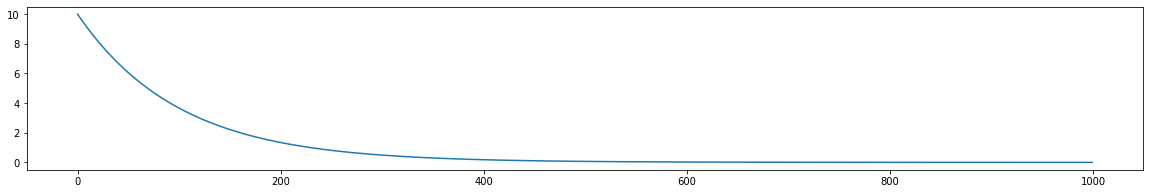

In [559]:
plt.plot([exponential_schedule(i, 10, 1, .99**i) for i in range(1000)])

In [418]:
# # variance_list = [100, 1000, 20000]
# var_list = [1., 2., 5.]
# for var in var_list:
#     x_noise = add_noise(x_arr, var)
#     nb = NaiveBayes(3).fit(x_noise, labels)
#     y_pred = nb.predict(x_noise)
#     print ("Noisy Image with var", var)
#     plt.imshow(x_noise, cmap='gray')
#     plt.show()
#     print ("Naive Bayes Classifier Labels")
#     plt.imshow(y_pred, cmap='gray')
#     plt.show()
#     break

In [477]:
model2 = MRF(3, beta=1, start_temperature=1000., verbose=500, delta_th=-600, workers=8)
start_dt = time.time()
a,b = model2.fit(x_noise, labels, 2000000)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)
y_pred = np.vectorize(label_to_value.__getitem__)(a)
plt.imshow(y_pred/255., 'gray')
plt.title(f'MRF: {np.mean(y_pred == arr):.4f}')
plt.show();

step 500 - 0s 0s/step - energy : 268270.7042 - acc : 0.5297
step 1000 - 0s 0s/step - energy : 268241.5593 - acc : 0.5296
step 1500 - 0s 0s/step - energy : 268211.4670 - acc : 0.5295
step 2000 - 0s 0s/step - energy : 268181.3420 - acc : 0.5293
step 2500 - 0s 0s/step - energy : 268147.7391 - acc : 0.5291
step 3000 - 0s 0s/step - energy : 268117.6901 - acc : 0.5289
step 3500 - 0s 0s/step - energy : 268082.4481 - acc : 0.5288
step 4000 - 0s 0s/step - energy : 268047.9863 - acc : 0.5286
step 4500 - 0s 0s/step - energy : 268020.1279 - acc : 0.5285
step 5000 - 0s 0s/step - energy : 267983.7035 - acc : 0.5282
step 5500 - 0s 0s/step - energy : 267952.8040 - acc : 0.5280
step 6000 - 0s 0s/step - energy : 267923.5661 - acc : 0.5279
step 6500 - 0s 0s/step - energy : 267892.2180 - acc : 0.5276
step 7000 - 0s 0s/step - energy : 267867.3984 - acc : 0.5275
step 7500 - 0s 0s/step - energy : 267837.5667 - acc : 0.5273
step 8000 - 0s 0s/step - energy : 267808.1256 - acc : 0.5271
step 8500 - 0s 0s/step - 

step 71000 - 2s 0s/step - energy : 264404.8793 - acc : 0.5085
step 71500 - 2s 0s/step - energy : 264377.6370 - acc : 0.5083
step 72000 - 2s 0s/step - energy : 264351.4813 - acc : 0.5082
step 72500 - 2s 0s/step - energy : 264333.0800 - acc : 0.5081
step 73000 - 2s 0s/step - energy : 264307.7467 - acc : 0.5080
step 73500 - 2s 0s/step - energy : 264282.7073 - acc : 0.5079
step 74000 - 2s 0s/step - energy : 264262.3429 - acc : 0.5077
step 74500 - 2s 0s/step - energy : 264237.6896 - acc : 0.5076
step 75000 - 2s 0s/step - energy : 264216.7580 - acc : 0.5075
step 75500 - 2s 0s/step - energy : 264190.7840 - acc : 0.5074
step 76000 - 3s 0s/step - energy : 264169.3680 - acc : 0.5072
step 76500 - 3s 0s/step - energy : 264148.8815 - acc : 0.5071
step 77000 - 3s 0s/step - energy : 264126.4138 - acc : 0.5069
step 77500 - 3s 0s/step - energy : 264100.6659 - acc : 0.5068
step 78000 - 3s 0s/step - energy : 264077.5235 - acc : 0.5067
step 78500 - 3s 0s/step - energy : 264055.5936 - acc : 0.5066
step 790

step 137000 - 5s 0s/step - energy : 261421.3488 - acc : 0.4930
step 137500 - 5s 0s/step - energy : 261402.3591 - acc : 0.4929
step 138000 - 5s 0s/step - energy : 261379.2087 - acc : 0.4928
step 138500 - 5s 0s/step - energy : 261355.3153 - acc : 0.4927
step 139000 - 5s 0s/step - energy : 261332.4730 - acc : 0.4926
step 139500 - 5s 0s/step - energy : 261314.4756 - acc : 0.4925
step 140000 - 5s 0s/step - energy : 261290.9323 - acc : 0.4924
step 140500 - 5s 0s/step - energy : 261265.3972 - acc : 0.4923
step 141000 - 5s 0s/step - energy : 261245.5628 - acc : 0.4922
step 141500 - 5s 0s/step - energy : 261226.1106 - acc : 0.4921
step 142000 - 5s 0s/step - energy : 261204.5276 - acc : 0.4920
step 142500 - 5s 0s/step - energy : 261184.0991 - acc : 0.4919
step 143000 - 5s 0s/step - energy : 261155.6537 - acc : 0.4917
step 143500 - 5s 0s/step - energy : 261133.9098 - acc : 0.4917
step 144000 - 5s 0s/step - energy : 261111.8194 - acc : 0.4916
step 144500 - 5s 0s/step - energy : 261085.8590 - acc :

KeyboardInterrupt: 

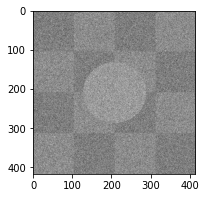

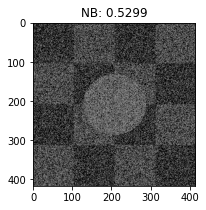

step 500 - 0s 0s/step - energy : 180719.3502 - acc : 0.5300
step 1000 - 0s 0s/step - energy : 180343.4706 - acc : 0.5301
step 1500 - 0s 0s/step - energy : 179928.7485 - acc : 0.5302
step 2000 - 0s 0s/step - energy : 179644.4797 - acc : 0.5303
step 2500 - 0s 0s/step - energy : 179363.0337 - acc : 0.5304
step 3000 - 0s 0s/step - energy : 179054.7753 - acc : 0.5305
step 3500 - 0s 0s/step - energy : 178713.8863 - acc : 0.5307
step 4000 - 0s 0s/step - energy : 178420.5224 - acc : 0.5308
step 4500 - 0s 0s/step - energy : 178120.6471 - acc : 0.5309
step 5000 - 0s 0s/step - energy : 177841.6084 - acc : 0.5309
step 5500 - 0s 0s/step - energy : 177499.0783 - acc : 0.5310
step 6000 - 1s 0s/step - energy : 177219.1200 - acc : 0.5310
step 6500 - 1s 0s/step - energy : 176877.1323 - acc : 0.5311
step 7000 - 1s 0s/step - energy : 176505.7287 - acc : 0.5311
step 7500 - 1s 0s/step - energy : 176215.5279 - acc : 0.5313
step 8000 - 1s 0s/step - energy : 175838.1499 - acc : 0.5313
step 8500 - 1s 0s/step - 

step 68000 - 11s 0s/step - energy : 140260.5230 - acc : 0.5418
step 68500 - 11s 0s/step - energy : 139994.3036 - acc : 0.5419
step 69000 - 11s 0s/step - energy : 139707.2501 - acc : 0.5420
step 69500 - 11s 0s/step - energy : 139460.3858 - acc : 0.5421
step 70000 - 11s 0s/step - energy : 139204.6870 - acc : 0.5422
step 70500 - 11s 0s/step - energy : 138929.1514 - acc : 0.5423
step 71000 - 12s 0s/step - energy : 138721.2951 - acc : 0.5424
step 71500 - 12s 0s/step - energy : 138440.3323 - acc : 0.5425
step 72000 - 12s 0s/step - energy : 138170.0375 - acc : 0.5425
step 72500 - 12s 0s/step - energy : 137866.6470 - acc : 0.5427
step 73000 - 12s 0s/step - energy : 137606.3144 - acc : 0.5427
step 73500 - 12s 0s/step - energy : 137304.9762 - acc : 0.5428
step 74000 - 12s 0s/step - energy : 137039.2625 - acc : 0.5429
step 74500 - 12s 0s/step - energy : 136757.2696 - acc : 0.5431
step 75000 - 12s 0s/step - energy : 136484.4832 - acc : 0.5432
step 75500 - 12s 0s/step - energy : 136163.7355 - acc :

step 134000 - 22s 0s/step - energy : 105358.7912 - acc : 0.5541
step 134500 - 22s 0s/step - energy : 105129.6180 - acc : 0.5542
step 135000 - 22s 0s/step - energy : 104893.0417 - acc : 0.5542
step 135500 - 22s 0s/step - energy : 104658.6557 - acc : 0.5543
step 136000 - 22s 0s/step - energy : 104399.3139 - acc : 0.5545
step 136500 - 23s 0s/step - energy : 104107.2552 - acc : 0.5547
step 137000 - 23s 0s/step - energy : 103902.0594 - acc : 0.5547
step 137500 - 23s 0s/step - energy : 103681.6980 - acc : 0.5549
step 138000 - 23s 0s/step - energy : 103443.5339 - acc : 0.5550
step 138500 - 23s 0s/step - energy : 103144.2864 - acc : 0.5551
step 139000 - 23s 0s/step - energy : 102857.5132 - acc : 0.5553
step 139500 - 23s 0s/step - energy : 102669.4866 - acc : 0.5554
step 140000 - 23s 0s/step - energy : 102429.2864 - acc : 0.5555
step 140500 - 23s 0s/step - energy : 102213.4286 - acc : 0.5556
step 141000 - 23s 0s/step - energy : 101924.2874 - acc : 0.5556
step 141500 - 23s 0s/step - energy : 101

step 200000 - 33s 0s/step - energy : 73733.8294 - acc : 0.5671
step 200500 - 33s 0s/step - energy : 73497.0586 - acc : 0.5672
step 201000 - 33s 0s/step - energy : 73287.7115 - acc : 0.5672
step 201500 - 34s 0s/step - energy : 73049.4163 - acc : 0.5673
step 202000 - 34s 0s/step - energy : 72812.0228 - acc : 0.5674
step 202500 - 34s 0s/step - energy : 72543.7818 - acc : 0.5675
step 203000 - 34s 0s/step - energy : 72308.8564 - acc : 0.5675
step 203500 - 34s 0s/step - energy : 72074.3113 - acc : 0.5676
step 204000 - 34s 0s/step - energy : 71820.4167 - acc : 0.5677
step 204500 - 34s 0s/step - energy : 71574.8107 - acc : 0.5679
step 205000 - 34s 0s/step - energy : 71350.8651 - acc : 0.5680
step 205500 - 34s 0s/step - energy : 71162.0426 - acc : 0.5680
step 206000 - 34s 0s/step - energy : 70947.4257 - acc : 0.5680
step 206500 - 34s 0s/step - energy : 70702.1750 - acc : 0.5681
step 207000 - 34s 0s/step - energy : 70507.2609 - acc : 0.5682
step 207500 - 35s 0s/step - energy : 70220.3896 - acc :

step 266000 - 44s 0s/step - energy : 43641.3929 - acc : 0.5797
step 266500 - 44s 0s/step - energy : 43437.9194 - acc : 0.5797
step 267000 - 45s 0s/step - energy : 43241.6830 - acc : 0.5799
step 267500 - 45s 0s/step - energy : 43058.1331 - acc : 0.5800
step 268000 - 45s 0s/step - energy : 42836.5592 - acc : 0.5800
step 268500 - 45s 0s/step - energy : 42576.2349 - acc : 0.5801
step 269000 - 45s 0s/step - energy : 42409.8223 - acc : 0.5802
step 269500 - 45s 0s/step - energy : 42214.0190 - acc : 0.5802
step 270000 - 45s 0s/step - energy : 41969.9749 - acc : 0.5804
step 270500 - 45s 0s/step - energy : 41790.7914 - acc : 0.5804
step 271000 - 45s 0s/step - energy : 41592.8615 - acc : 0.5805
step 271500 - 45s 0s/step - energy : 41397.0093 - acc : 0.5806
step 272000 - 45s 0s/step - energy : 41113.9862 - acc : 0.5807
step 272500 - 45s 0s/step - energy : 40896.2033 - acc : 0.5808
step 273000 - 46s 0s/step - energy : 40688.2073 - acc : 0.5809
step 273500 - 46s 0s/step - energy : 40504.0396 - acc :

step 332000 - 55s 0s/step - energy : 15752.2303 - acc : 0.5917
step 332500 - 56s 0s/step - energy : 15546.0442 - acc : 0.5918
step 333000 - 56s 0s/step - energy : 15330.0764 - acc : 0.5919
step 333500 - 56s 0s/step - energy : 15073.1432 - acc : 0.5920
step 334000 - 56s 0s/step - energy : 14789.2112 - acc : 0.5921
step 334500 - 56s 0s/step - energy : 14564.7332 - acc : 0.5923
step 335000 - 56s 0s/step - energy : 14411.1343 - acc : 0.5923
step 335500 - 56s 0s/step - energy : 14243.9260 - acc : 0.5924
step 336000 - 56s 0s/step - energy : 14055.3341 - acc : 0.5925
step 336500 - 56s 0s/step - energy : 13842.2228 - acc : 0.5927
step 337000 - 56s 0s/step - energy : 13627.3475 - acc : 0.5927
step 337500 - 56s 0s/step - energy : 13325.9209 - acc : 0.5929
step 338000 - 56s 0s/step - energy : 13047.2585 - acc : 0.5930
step 338500 - 56s 0s/step - energy : 12780.3802 - acc : 0.5931
step 339000 - 57s 0s/step - energy : 12585.7133 - acc : 0.5932
step 339500 - 57s 0s/step - energy : 12378.8704 - acc :

step 398000 - 67s 0s/step - energy : -11176.0766 - acc : 0.6042
step 398500 - 67s 0s/step - energy : -11309.2876 - acc : 0.6042
step 399000 - 67s 0s/step - energy : -11476.7815 - acc : 0.6042
step 399500 - 67s 0s/step - energy : -11616.8027 - acc : 0.6043
step 400000 - 67s 0s/step - energy : -11794.9345 - acc : 0.6044
step 400500 - 67s 0s/step - energy : -11933.5119 - acc : 0.6045
step 401000 - 67s 0s/step - energy : -12136.1685 - acc : 0.6045
step 401500 - 67s 0s/step - energy : -12261.6589 - acc : 0.6046
step 402000 - 67s 0s/step - energy : -12412.7794 - acc : 0.6046
step 402500 - 67s 0s/step - energy : -12649.7960 - acc : 0.6047
step 403000 - 67s 0s/step - energy : -12855.1223 - acc : 0.6048
step 403500 - 67s 0s/step - energy : -12993.3168 - acc : 0.6049
step 404000 - 68s 0s/step - energy : -13185.7390 - acc : 0.6050
step 404500 - 68s 0s/step - energy : -13346.8623 - acc : 0.6051
step 405000 - 68s 0s/step - energy : -13510.8951 - acc : 0.6052
step 405500 - 68s 0s/step - energy : -13

step 462500 - 77s 0s/step - energy : -34514.3096 - acc : 0.6153
step 463000 - 77s 0s/step - energy : -34735.1080 - acc : 0.6155
step 463500 - 78s 0s/step - energy : -34973.9147 - acc : 0.6156
step 464000 - 78s 0s/step - energy : -35135.1604 - acc : 0.6157
step 464500 - 78s 0s/step - energy : -35295.2522 - acc : 0.6158
step 465000 - 78s 0s/step - energy : -35465.0148 - acc : 0.6159
step 465500 - 78s 0s/step - energy : -35680.5233 - acc : 0.6160
step 466000 - 78s 0s/step - energy : -35845.4463 - acc : 0.6160
step 466500 - 78s 0s/step - energy : -36079.4174 - acc : 0.6162
step 467000 - 78s 0s/step - energy : -36280.8185 - acc : 0.6162
step 467500 - 78s 0s/step - energy : -36494.4580 - acc : 0.6163
step 468000 - 78s 0s/step - energy : -36764.0181 - acc : 0.6164
step 468500 - 78s 0s/step - energy : -36974.0796 - acc : 0.6165
step 469000 - 79s 0s/step - energy : -37164.5418 - acc : 0.6165
step 469500 - 79s 0s/step - energy : -37351.2625 - acc : 0.6166
step 470000 - 79s 0s/step - energy : -37

step 527000 - 88s 0s/step - energy : -58036.0380 - acc : 0.6262
step 527500 - 88s 0s/step - energy : -58196.7495 - acc : 0.6262
step 528000 - 88s 0s/step - energy : -58342.8250 - acc : 0.6263
step 528500 - 88s 0s/step - energy : -58497.7646 - acc : 0.6264
step 529000 - 89s 0s/step - energy : -58701.6280 - acc : 0.6265
step 529500 - 89s 0s/step - energy : -58843.4424 - acc : 0.6265
step 530000 - 89s 0s/step - energy : -59072.7054 - acc : 0.6265
step 530500 - 89s 0s/step - energy : -59273.6392 - acc : 0.6266
step 531000 - 89s 0s/step - energy : -59403.7785 - acc : 0.6267
step 531500 - 89s 0s/step - energy : -59619.3365 - acc : 0.6268
step 532000 - 89s 0s/step - energy : -59818.7295 - acc : 0.6269
step 532500 - 89s 0s/step - energy : -60043.3646 - acc : 0.6270
step 533000 - 89s 0s/step - energy : -60199.7467 - acc : 0.6270
step 533500 - 89s 0s/step - energy : -60447.1018 - acc : 0.6271
step 534000 - 89s 0s/step - energy : -60629.4303 - acc : 0.6272
step 534500 - 89s 0s/step - energy : -60

step 591500 - 99s 0s/step - energy : -79688.5607 - acc : 0.6352
step 592000 - 99s 0s/step - energy : -79823.8633 - acc : 0.6352
step 592500 - 99s 0s/step - energy : -79980.1802 - acc : 0.6353
step 593000 - 99s 0s/step - energy : -80160.6501 - acc : 0.6353
step 593500 - 99s 0s/step - energy : -80295.1006 - acc : 0.6354
step 594000 - 99s 0s/step - energy : -80434.7586 - acc : 0.6354
step 594500 - 100s 0s/step - energy : -80562.1101 - acc : 0.6355
step 595000 - 100s 0s/step - energy : -80719.1980 - acc : 0.6356
step 595500 - 100s 0s/step - energy : -80873.7521 - acc : 0.6356
step 596000 - 100s 0s/step - energy : -80995.2671 - acc : 0.6356
step 596500 - 100s 0s/step - energy : -81166.3036 - acc : 0.6357
step 597000 - 100s 0s/step - energy : -81360.2719 - acc : 0.6358
step 597500 - 100s 0s/step - energy : -81537.4889 - acc : 0.6359
step 598000 - 100s 0s/step - energy : -81712.1564 - acc : 0.6359
step 598500 - 100s 0s/step - energy : -81857.3849 - acc : 0.6360
step 599000 - 100s 0s/step - en

step 656000 - 110s 0s/step - energy : -99907.5952 - acc : 0.6444
step 656500 - 110s 0s/step - energy : -100009.2134 - acc : 0.6445
step 657000 - 110s 0s/step - energy : -100163.3293 - acc : 0.6445
step 657500 - 110s 0s/step - energy : -100249.7841 - acc : 0.6446
step 658000 - 110s 0s/step - energy : -100383.7730 - acc : 0.6447
step 658500 - 110s 0s/step - energy : -100554.3938 - acc : 0.6448
step 659000 - 110s 0s/step - energy : -100688.6397 - acc : 0.6448
step 659500 - 110s 0s/step - energy : -100837.3492 - acc : 0.6448
step 660000 - 110s 0s/step - energy : -101043.6308 - acc : 0.6449
step 660500 - 111s 0s/step - energy : -101213.2960 - acc : 0.6450
step 661000 - 111s 0s/step - energy : -101404.4325 - acc : 0.6451
step 661500 - 111s 0s/step - energy : -101518.6943 - acc : 0.6452
step 662000 - 111s 0s/step - energy : -101644.3878 - acc : 0.6452
step 662500 - 111s 0s/step - energy : -101768.4030 - acc : 0.6452
step 663000 - 111s 0s/step - energy : -101924.4809 - acc : 0.6453
step 663500

step 719000 - 120s 0s/step - energy : -118393.3707 - acc : 0.6528
step 719500 - 120s 0s/step - energy : -118530.3779 - acc : 0.6529
step 720000 - 120s 0s/step - energy : -118658.9252 - acc : 0.6530
step 720500 - 121s 0s/step - energy : -118809.9719 - acc : 0.6530
step 721000 - 121s 0s/step - energy : -118954.7708 - acc : 0.6530
step 721500 - 121s 0s/step - energy : -119091.1337 - acc : 0.6531
step 722000 - 121s 0s/step - energy : -119309.2885 - acc : 0.6531
step 722500 - 121s 0s/step - energy : -119464.6392 - acc : 0.6532
step 723000 - 121s 0s/step - energy : -119603.2254 - acc : 0.6533
step 723500 - 121s 0s/step - energy : -119762.4914 - acc : 0.6533
step 724000 - 121s 0s/step - energy : -119950.8236 - acc : 0.6534
step 724500 - 121s 0s/step - energy : -120118.2671 - acc : 0.6535
step 725000 - 121s 0s/step - energy : -120246.9146 - acc : 0.6535
step 725500 - 121s 0s/step - energy : -120453.8715 - acc : 0.6536
step 726000 - 121s 0s/step - energy : -120624.4330 - acc : 0.6536
step 72650

step 782000 - 131s 0s/step - energy : -136345.6798 - acc : 0.6597
step 782500 - 131s 0s/step - energy : -136518.7804 - acc : 0.6598
step 783000 - 131s 0s/step - energy : -136645.9697 - acc : 0.6598
step 783500 - 131s 0s/step - energy : -136801.8771 - acc : 0.6599
step 784000 - 131s 0s/step - energy : -136903.3098 - acc : 0.6598
step 784500 - 132s 0s/step - energy : -137066.8500 - acc : 0.6599
step 785000 - 132s 0s/step - energy : -137249.5050 - acc : 0.6601
step 785500 - 132s 0s/step - energy : -137394.6403 - acc : 0.6601
step 786000 - 132s 0s/step - energy : -137507.7728 - acc : 0.6602
step 786500 - 132s 0s/step - energy : -137625.6683 - acc : 0.6602
step 787000 - 132s 0s/step - energy : -137782.3687 - acc : 0.6603
step 787500 - 132s 0s/step - energy : -137975.1087 - acc : 0.6603
step 788000 - 132s 0s/step - energy : -138131.7185 - acc : 0.6604
step 788500 - 132s 0s/step - energy : -138331.4436 - acc : 0.6605
step 789000 - 132s 0s/step - energy : -138481.4622 - acc : 0.6605
step 78950

step 845000 - 142s 0s/step - energy : -153832.9471 - acc : 0.6671
step 845500 - 142s 0s/step - energy : -153936.2159 - acc : 0.6672
step 846000 - 142s 0s/step - energy : -154044.0599 - acc : 0.6672
step 846500 - 142s 0s/step - energy : -154144.2616 - acc : 0.6673
step 847000 - 142s 0s/step - energy : -154291.4803 - acc : 0.6673
step 847500 - 142s 0s/step - energy : -154377.0114 - acc : 0.6674
step 848000 - 142s 0s/step - energy : -154525.7849 - acc : 0.6674
step 848500 - 142s 0s/step - energy : -154633.2333 - acc : 0.6675
step 849000 - 142s 0s/step - energy : -154751.4785 - acc : 0.6675
step 849500 - 142s 0s/step - energy : -154861.0704 - acc : 0.6676
step 850000 - 142s 0s/step - energy : -155014.6753 - acc : 0.6677
step 850500 - 143s 0s/step - energy : -155167.5721 - acc : 0.6677
step 851000 - 143s 0s/step - energy : -155286.8384 - acc : 0.6677
step 851500 - 143s 0s/step - energy : -155385.1581 - acc : 0.6677
step 852000 - 143s 0s/step - energy : -155526.2710 - acc : 0.6678
step 85250

step 908000 - 152s 0s/step - energy : -168968.1039 - acc : 0.6734
step 908500 - 152s 0s/step - energy : -169057.1452 - acc : 0.6735
step 909000 - 153s 0s/step - energy : -169178.9102 - acc : 0.6735
step 909500 - 153s 0s/step - energy : -169319.7799 - acc : 0.6735
step 910000 - 153s 0s/step - energy : -169420.9666 - acc : 0.6736
step 910500 - 153s 0s/step - energy : -169522.3332 - acc : 0.6736
step 911000 - 153s 0s/step - energy : -169689.0210 - acc : 0.6737
step 911500 - 153s 0s/step - energy : -169833.1571 - acc : 0.6738
step 912000 - 153s 0s/step - energy : -169970.8262 - acc : 0.6738
step 912500 - 153s 0s/step - energy : -170031.4522 - acc : 0.6738
step 913000 - 153s 0s/step - energy : -170140.3173 - acc : 0.6738
step 913500 - 153s 0s/step - energy : -170298.4537 - acc : 0.6738
step 914000 - 153s 0s/step - energy : -170404.9221 - acc : 0.6739
step 914500 - 153s 0s/step - energy : -170586.2797 - acc : 0.6739
step 915000 - 154s 0s/step - energy : -170698.1463 - acc : 0.6739
step 91550

step 971000 - 163s 0s/step - energy : -183754.9246 - acc : 0.6785
step 971500 - 163s 0s/step - energy : -183849.4296 - acc : 0.6786
step 972000 - 163s 0s/step - energy : -183971.7899 - acc : 0.6786
step 972500 - 163s 0s/step - energy : -184108.4195 - acc : 0.6786
step 973000 - 163s 0s/step - energy : -184177.5060 - acc : 0.6787
step 973500 - 163s 0s/step - energy : -184277.3031 - acc : 0.6787
step 974000 - 163s 0s/step - energy : -184412.2793 - acc : 0.6787
step 974500 - 163s 0s/step - energy : -184557.8911 - acc : 0.6788
step 975000 - 164s 0s/step - energy : -184680.5843 - acc : 0.6788
step 975500 - 164s 0s/step - energy : -184799.1474 - acc : 0.6788
step 976000 - 164s 0s/step - energy : -184913.4885 - acc : 0.6788
step 976500 - 164s 0s/step - energy : -184992.3832 - acc : 0.6788
step 977000 - 164s 0s/step - energy : -185105.4622 - acc : 0.6789
step 977500 - 164s 0s/step - energy : -185230.4865 - acc : 0.6789
step 978000 - 164s 0s/step - energy : -185317.0457 - acc : 0.6790
step 97850

step 1034000 - 173s 0s/step - energy : -197417.2496 - acc : 0.6829
step 1034500 - 174s 0s/step - energy : -197538.3986 - acc : 0.6830
step 1035000 - 174s 0s/step - energy : -197657.6295 - acc : 0.6830
step 1035500 - 174s 0s/step - energy : -197757.6290 - acc : 0.6830
step 1036000 - 174s 0s/step - energy : -197864.0100 - acc : 0.6831
step 1036500 - 174s 0s/step - energy : -197968.5488 - acc : 0.6831
step 1037000 - 174s 0s/step - energy : -198075.8481 - acc : 0.6832
step 1037500 - 174s 0s/step - energy : -198156.3137 - acc : 0.6832
step 1038000 - 174s 0s/step - energy : -198289.5186 - acc : 0.6832
step 1038500 - 174s 0s/step - energy : -198372.3130 - acc : 0.6833
step 1039000 - 174s 0s/step - energy : -198507.0996 - acc : 0.6833
step 1039500 - 174s 0s/step - energy : -198648.3076 - acc : 0.6834
step 1040000 - 174s 0s/step - energy : -198766.2364 - acc : 0.6834
step 1040500 - 175s 0s/step - energy : -198844.3891 - acc : 0.6833
step 1041000 - 175s 0s/step - energy : -198954.9751 - acc : 0.

step 1095500 - 184s 0s/step - energy : -210447.0266 - acc : 0.6874
step 1096000 - 184s 0s/step - energy : -210579.1039 - acc : 0.6874
step 1096500 - 184s 0s/step - energy : -210672.5163 - acc : 0.6874
step 1097000 - 184s 0s/step - energy : -210742.4304 - acc : 0.6874
step 1097500 - 184s 0s/step - energy : -210813.0984 - acc : 0.6874
step 1098000 - 184s 0s/step - energy : -210895.5562 - acc : 0.6875
step 1098500 - 184s 0s/step - energy : -211026.6889 - acc : 0.6875
step 1099000 - 185s 0s/step - energy : -211163.2972 - acc : 0.6876
step 1099500 - 185s 0s/step - energy : -211232.1754 - acc : 0.6876
step 1100000 - 185s 0s/step - energy : -211328.3236 - acc : 0.6877
step 1100500 - 185s 0s/step - energy : -211401.4142 - acc : 0.6877
step 1101000 - 185s 0s/step - energy : -211498.2491 - acc : 0.6877
step 1101500 - 185s 0s/step - energy : -211594.6917 - acc : 0.6877
step 1102000 - 185s 0s/step - energy : -211674.5148 - acc : 0.6878
step 1102500 - 185s 0s/step - energy : -211776.0662 - acc : 0.

step 1157000 - 194s 0s/step - energy : -222899.5829 - acc : 0.6915
step 1157500 - 195s 0s/step - energy : -222990.3624 - acc : 0.6916
step 1158000 - 195s 0s/step - energy : -223081.7914 - acc : 0.6917
step 1158500 - 195s 0s/step - energy : -223167.4853 - acc : 0.6917
step 1159000 - 195s 0s/step - energy : -223254.8236 - acc : 0.6918
step 1159500 - 195s 0s/step - energy : -223335.1996 - acc : 0.6918
step 1160000 - 195s 0s/step - energy : -223435.8298 - acc : 0.6918
step 1160500 - 195s 0s/step - energy : -223554.6133 - acc : 0.6919
step 1161000 - 195s 0s/step - energy : -223662.5891 - acc : 0.6919
step 1161500 - 195s 0s/step - energy : -223762.5265 - acc : 0.6920
step 1162000 - 195s 0s/step - energy : -223825.6721 - acc : 0.6920
step 1162500 - 195s 0s/step - energy : -223940.1904 - acc : 0.6920
step 1163000 - 195s 0s/step - energy : -224026.4402 - acc : 0.6921
step 1163500 - 195s 0s/step - energy : -224112.5913 - acc : 0.6921
step 1164000 - 196s 0s/step - energy : -224197.6696 - acc : 0.

step 1218500 - 205s 0s/step - energy : -234295.0845 - acc : 0.6954
step 1219000 - 205s 0s/step - energy : -234396.1245 - acc : 0.6955
step 1219500 - 205s 0s/step - energy : -234499.5602 - acc : 0.6955
step 1220000 - 205s 0s/step - energy : -234590.8383 - acc : 0.6955
step 1220500 - 205s 0s/step - energy : -234668.5865 - acc : 0.6955
step 1221000 - 205s 0s/step - energy : -234735.8065 - acc : 0.6955
step 1221500 - 205s 0s/step - energy : -234803.9098 - acc : 0.6956
step 1222000 - 205s 0s/step - energy : -234864.6687 - acc : 0.6956
step 1222500 - 205s 0s/step - energy : -234977.9295 - acc : 0.6956
step 1223000 - 205s 0s/step - energy : -235031.0106 - acc : 0.6956
step 1223500 - 206s 0s/step - energy : -235121.9900 - acc : 0.6957
step 1224000 - 206s 0s/step - energy : -235235.6155 - acc : 0.6957
step 1224500 - 206s 0s/step - energy : -235307.2121 - acc : 0.6957
step 1225000 - 206s 0s/step - energy : -235422.6686 - acc : 0.6957
step 1225500 - 206s 0s/step - energy : -235523.6250 - acc : 0.

step 1280000 - 215s 0s/step - energy : -245523.0390 - acc : 0.6990
step 1280500 - 215s 0s/step - energy : -245606.2182 - acc : 0.6990
step 1281000 - 215s 0s/step - energy : -245698.9248 - acc : 0.6991
step 1281500 - 216s 0s/step - energy : -245816.9483 - acc : 0.6991
step 1282000 - 216s 0s/step - energy : -245885.2245 - acc : 0.6991
step 1282500 - 216s 0s/step - energy : -245955.3814 - acc : 0.6991
step 1283000 - 216s 0s/step - energy : -246025.8038 - acc : 0.6992
step 1283500 - 216s 0s/step - energy : -246085.8252 - acc : 0.6992
step 1284000 - 216s 0s/step - energy : -246151.0300 - acc : 0.6992
step 1284500 - 216s 0s/step - energy : -246243.8582 - acc : 0.6992
step 1285000 - 216s 0s/step - energy : -246353.0205 - acc : 0.6993
step 1285500 - 216s 0s/step - energy : -246443.3947 - acc : 0.6993
step 1286000 - 216s 0s/step - energy : -246509.3665 - acc : 0.6993
step 1286500 - 216s 0s/step - energy : -246618.7462 - acc : 0.6993
step 1287000 - 216s 0s/step - energy : -246746.1390 - acc : 0.

step 1341500 - 226s 0s/step - energy : -255670.0474 - acc : 0.7017
step 1342000 - 226s 0s/step - energy : -255761.4199 - acc : 0.7017
step 1342500 - 226s 0s/step - energy : -255836.2506 - acc : 0.7017
step 1343000 - 226s 0s/step - energy : -255902.4380 - acc : 0.7018
step 1343500 - 226s 0s/step - energy : -255952.2016 - acc : 0.7018
step 1344000 - 226s 0s/step - energy : -256018.8901 - acc : 0.7018
step 1344500 - 226s 0s/step - energy : -256131.3621 - acc : 0.7019
step 1345000 - 226s 0s/step - energy : -256197.5436 - acc : 0.7019
step 1345500 - 226s 0s/step - energy : -256260.1767 - acc : 0.7019
step 1346000 - 226s 0s/step - energy : -256352.6364 - acc : 0.7019
step 1346500 - 226s 0s/step - energy : -256430.2030 - acc : 0.7019
step 1347000 - 226s 0s/step - energy : -256490.9662 - acc : 0.7019
step 1347500 - 227s 0s/step - energy : -256542.7388 - acc : 0.7019
step 1348000 - 227s 0s/step - energy : -256657.0413 - acc : 0.7020
step 1348500 - 227s 0s/step - energy : -256786.4169 - acc : 0.

step 1403000 - 236s 0s/step - energy : -265763.8464 - acc : 0.7043
step 1403500 - 236s 0s/step - energy : -265870.3398 - acc : 0.7043
step 1404000 - 236s 0s/step - energy : -265931.6788 - acc : 0.7044
step 1404500 - 236s 0s/step - energy : -266034.2037 - acc : 0.7044
step 1405000 - 236s 0s/step - energy : -266134.1834 - acc : 0.7044
step 1405500 - 236s 0s/step - energy : -266221.0147 - acc : 0.7044
step 1406000 - 236s 0s/step - energy : -266275.4465 - acc : 0.7044
step 1406500 - 236s 0s/step - energy : -266388.7450 - acc : 0.7044
step 1407000 - 236s 0s/step - energy : -266461.2228 - acc : 0.7044
step 1407500 - 237s 0s/step - energy : -266517.3044 - acc : 0.7045
step 1408000 - 237s 0s/step - energy : -266562.1289 - acc : 0.7044
step 1408500 - 237s 0s/step - energy : -266646.1198 - acc : 0.7044
step 1409000 - 237s 0s/step - energy : -266721.2821 - acc : 0.7045
step 1409500 - 237s 0s/step - energy : -266806.9320 - acc : 0.7045
step 1410000 - 237s 0s/step - energy : -266874.3210 - acc : 0.

step 1464500 - 246s 0s/step - energy : -275420.3511 - acc : 0.7067
step 1465000 - 246s 0s/step - energy : -275463.9171 - acc : 0.7067
step 1465500 - 247s 0s/step - energy : -275498.4042 - acc : 0.7067
step 1466000 - 247s 0s/step - energy : -275562.0097 - acc : 0.7067
step 1466500 - 247s 0s/step - energy : -275636.7061 - acc : 0.7066
step 1467000 - 247s 0s/step - energy : -275709.7636 - acc : 0.7067
step 1467500 - 247s 0s/step - energy : -275742.3440 - acc : 0.7066
step 1468000 - 247s 0s/step - energy : -275827.9122 - acc : 0.7066
step 1468500 - 247s 0s/step - energy : -275929.4879 - acc : 0.7066
step 1469000 - 247s 0s/step - energy : -276012.8009 - acc : 0.7066
step 1469500 - 247s 0s/step - energy : -276110.7816 - acc : 0.7067
step 1470000 - 247s 0s/step - energy : -276203.9997 - acc : 0.7067
step 1470500 - 247s 0s/step - energy : -276295.3330 - acc : 0.7067
step 1471000 - 247s 0s/step - energy : -276367.3056 - acc : 0.7067
step 1471500 - 248s 0s/step - energy : -276442.4156 - acc : 0.

step 1526000 - 257s 0s/step - energy : -284748.2101 - acc : 0.7091
step 1526500 - 257s 0s/step - energy : -284852.1163 - acc : 0.7091
step 1527000 - 257s 0s/step - energy : -284924.3155 - acc : 0.7092
step 1527500 - 257s 0s/step - energy : -284997.1090 - acc : 0.7092
step 1528000 - 257s 0s/step - energy : -285063.4446 - acc : 0.7092
step 1528500 - 257s 0s/step - energy : -285113.4671 - acc : 0.7092
step 1529000 - 257s 0s/step - energy : -285207.5740 - acc : 0.7092
step 1529500 - 257s 0s/step - energy : -285283.1405 - acc : 0.7093
step 1530000 - 257s 0s/step - energy : -285368.6891 - acc : 0.7093
step 1530500 - 257s 0s/step - energy : -285488.3194 - acc : 0.7093
step 1531000 - 258s 0s/step - energy : -285546.6078 - acc : 0.7093
step 1531500 - 258s 0s/step - energy : -285638.3938 - acc : 0.7093
step 1532000 - 258s 0s/step - energy : -285724.7033 - acc : 0.7093
step 1532500 - 258s 0s/step - energy : -285798.0667 - acc : 0.7094
step 1533000 - 258s 0s/step - energy : -285885.7576 - acc : 0.

step 1587500 - 267s 0s/step - energy : -293644.3938 - acc : 0.7109
step 1588000 - 267s 0s/step - energy : -293709.8071 - acc : 0.7109
step 1588500 - 267s 0s/step - energy : -293739.9781 - acc : 0.7109
step 1589000 - 268s 0s/step - energy : -293811.0083 - acc : 0.7109
step 1589500 - 268s 0s/step - energy : -293913.0152 - acc : 0.7110
step 1590000 - 268s 0s/step - energy : -294013.9950 - acc : 0.7110
step 1590500 - 268s 0s/step - energy : -294087.9324 - acc : 0.7111
step 1591000 - 268s 0s/step - energy : -294177.1907 - acc : 0.7111
step 1591500 - 268s 0s/step - energy : -294250.0585 - acc : 0.7111
step 1592000 - 268s 0s/step - energy : -294340.0540 - acc : 0.7111
step 1592500 - 268s 0s/step - energy : -294430.0643 - acc : 0.7112
step 1593000 - 268s 0s/step - energy : -294500.7396 - acc : 0.7112
step 1593500 - 268s 0s/step - energy : -294563.0750 - acc : 0.7112
step 1594000 - 268s 0s/step - energy : -294623.3087 - acc : 0.7112
step 1594500 - 268s 0s/step - energy : -294692.0574 - acc : 0.

step 1649000 - 278s 0s/step - energy : -302402.6257 - acc : 0.7127
step 1649500 - 278s 0s/step - energy : -302465.7945 - acc : 0.7128
step 1650000 - 278s 0s/step - energy : -302529.9235 - acc : 0.7128
step 1650500 - 278s 0s/step - energy : -302602.0050 - acc : 0.7128
step 1651000 - 278s 0s/step - energy : -302658.5919 - acc : 0.7129
step 1651500 - 278s 0s/step - energy : -302750.6112 - acc : 0.7129
step 1652000 - 278s 0s/step - energy : -302803.2718 - acc : 0.7129
step 1652500 - 278s 0s/step - energy : -302885.8028 - acc : 0.7129
step 1653000 - 278s 0s/step - energy : -302953.3833 - acc : 0.7129
step 1653500 - 278s 0s/step - energy : -303041.4255 - acc : 0.7130
step 1654000 - 278s 0s/step - energy : -303107.9414 - acc : 0.7130
step 1654500 - 279s 0s/step - energy : -303205.1977 - acc : 0.7131
step 1655000 - 279s 0s/step - energy : -303264.1418 - acc : 0.7131
step 1655500 - 279s 0s/step - energy : -303289.5747 - acc : 0.7131
step 1656000 - 279s 0s/step - energy : -303393.5203 - acc : 0.

step 1710500 - 288s 0s/step - energy : -310832.2988 - acc : 0.7147
step 1711000 - 288s 0s/step - energy : -310886.6677 - acc : 0.7147
step 1711500 - 288s 0s/step - energy : -310954.3573 - acc : 0.7147
step 1712000 - 288s 0s/step - energy : -311023.8843 - acc : 0.7147
step 1712500 - 288s 0s/step - energy : -311093.0604 - acc : 0.7147
step 1713000 - 289s 0s/step - energy : -311178.5821 - acc : 0.7147
step 1713500 - 289s 0s/step - energy : -311231.1111 - acc : 0.7147
step 1714000 - 289s 0s/step - energy : -311302.3880 - acc : 0.7147
step 1714500 - 289s 0s/step - energy : -311369.4246 - acc : 0.7147
step 1715000 - 289s 0s/step - energy : -311408.2006 - acc : 0.7147
step 1715500 - 289s 0s/step - energy : -311469.9466 - acc : 0.7147
step 1716000 - 289s 0s/step - energy : -311555.1313 - acc : 0.7148
step 1716500 - 289s 0s/step - energy : -311602.7832 - acc : 0.7148
step 1717000 - 289s 0s/step - energy : -311664.5243 - acc : 0.7148
step 1717500 - 289s 0s/step - energy : -311734.4650 - acc : 0.

step 1772000 - 298s 0s/step - energy : -318727.2601 - acc : 0.7159
step 1772500 - 299s 0s/step - energy : -318784.9095 - acc : 0.7160
step 1773000 - 299s 0s/step - energy : -318868.1387 - acc : 0.7159
step 1773500 - 299s 0s/step - energy : -318914.8769 - acc : 0.7159
step 1774000 - 299s 0s/step - energy : -318976.1642 - acc : 0.7159
step 1774500 - 299s 0s/step - energy : -319039.6303 - acc : 0.7160
step 1775000 - 299s 0s/step - energy : -319085.2361 - acc : 0.7160
step 1775500 - 299s 0s/step - energy : -319144.2421 - acc : 0.7160
step 1776000 - 299s 0s/step - energy : -319176.6586 - acc : 0.7160
step 1776500 - 299s 0s/step - energy : -319245.1686 - acc : 0.7161
step 1777000 - 299s 0s/step - energy : -319295.4319 - acc : 0.7161
step 1777500 - 299s 0s/step - energy : -319393.4196 - acc : 0.7161
step 1778000 - 299s 0s/step - energy : -319437.9466 - acc : 0.7161
step 1778500 - 300s 0s/step - energy : -319512.7200 - acc : 0.7161
step 1779000 - 300s 0s/step - energy : -319557.3476 - acc : 0.

step 1833500 - 309s 0s/step - energy : -326504.2909 - acc : 0.7173
step 1834000 - 309s 0s/step - energy : -326546.0817 - acc : 0.7174
step 1834500 - 309s 0s/step - energy : -326625.9126 - acc : 0.7174
step 1835000 - 309s 0s/step - energy : -326665.8809 - acc : 0.7174
step 1835500 - 309s 0s/step - energy : -326724.6871 - acc : 0.7174
step 1836000 - 309s 0s/step - energy : -326777.7523 - acc : 0.7174
step 1836500 - 309s 0s/step - energy : -326815.9754 - acc : 0.7174
step 1837000 - 309s 0s/step - energy : -326878.1609 - acc : 0.7174
step 1837500 - 309s 0s/step - energy : -326944.7567 - acc : 0.7174
step 1838000 - 310s 0s/step - energy : -327019.9012 - acc : 0.7174
step 1838500 - 310s 0s/step - energy : -327070.9257 - acc : 0.7174
step 1839000 - 310s 0s/step - energy : -327144.9469 - acc : 0.7174
step 1839500 - 310s 0s/step - energy : -327217.8770 - acc : 0.7175
step 1840000 - 310s 0s/step - energy : -327286.3595 - acc : 0.7175
step 1840500 - 310s 0s/step - energy : -327344.3821 - acc : 0.

step 1895000 - 319s 0s/step - energy : -333921.8255 - acc : 0.7178
step 1895500 - 319s 0s/step - energy : -333980.9753 - acc : 0.7178
step 1896000 - 319s 0s/step - energy : -334024.9672 - acc : 0.7177
step 1896500 - 319s 0s/step - energy : -334057.5875 - acc : 0.7177
step 1897000 - 319s 0s/step - energy : -334138.9549 - acc : 0.7178
step 1897500 - 320s 0s/step - energy : -334192.9541 - acc : 0.7178
step 1898000 - 320s 0s/step - energy : -334248.7118 - acc : 0.7178
step 1898500 - 320s 0s/step - energy : -334317.3093 - acc : 0.7177
step 1899000 - 320s 0s/step - energy : -334371.2838 - acc : 0.7177
step 1899500 - 320s 0s/step - energy : -334392.1583 - acc : 0.7177
step 1900000 - 320s 0s/step - energy : -334445.0972 - acc : 0.7177
step 1900500 - 320s 0s/step - energy : -334511.7301 - acc : 0.7177
step 1901000 - 320s 0s/step - energy : -334593.4843 - acc : 0.7177
step 1901500 - 320s 0s/step - energy : -334638.8224 - acc : 0.7177
step 1902000 - 320s 0s/step - energy : -334689.8377 - acc : 0.

step 1956500 - 329s 0s/step - energy : -340671.8414 - acc : 0.7184
step 1957000 - 329s 0s/step - energy : -340746.4588 - acc : 0.7184
step 1957500 - 330s 0s/step - energy : -340795.3372 - acc : 0.7185
step 1958000 - 330s 0s/step - energy : -340851.1034 - acc : 0.7185
step 1958500 - 330s 0s/step - energy : -340900.7682 - acc : 0.7185
step 1959000 - 330s 0s/step - energy : -340958.9581 - acc : 0.7185
step 1959500 - 330s 0s/step - energy : -341043.6274 - acc : 0.7185
step 1960000 - 330s 0s/step - energy : -341111.9007 - acc : 0.7185
step 1960500 - 330s 0s/step - energy : -341141.1426 - acc : 0.7185
step 1961000 - 330s 0s/step - energy : -341203.6176 - acc : 0.7185
step 1961500 - 330s 0s/step - energy : -341262.0289 - acc : 0.7184
step 1962000 - 330s 0s/step - energy : -341323.4379 - acc : 0.7184
step 1962500 - 330s 0s/step - energy : -341382.1115 - acc : 0.7184
step 1963000 - 330s 0s/step - energy : -341427.4468 - acc : 0.7185
step 1963500 - 331s 0s/step - energy : -341453.5219 - acc : 0.

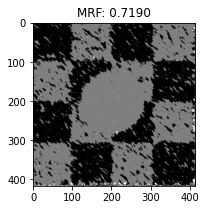

In [401]:
# x_noise = add_noise(x_arr, 1.)
plt.imshow(x_noise, 'gray')
plt.show();

nb = NaiveBayes(3)
nb.fit(x_noise, labels)
pred_nb = nb.predict(x_noise)
y_pred = np.vectorize(label_to_value.__getitem__)(pred_nb)
plt.imshow(y_pred/255., 'gray')
plt.title(f'NB: {np.mean(y_pred == arr):.4f}')
plt.show();

model = MRF(3, beta=1, start_temperature=1000., verbose=500, delta_th=-600, workers=8)
start_dt = time.time()
x_post, x_changed = model.fit(x_noise, labels, 2000000)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)
y_pred = np.vectorize(label_to_value.__getitem__)(x_post)
plt.imshow(y_pred/255., 'gray')
plt.title(f'MRF: {np.mean(y_pred == arr):.4f}')
plt.show();

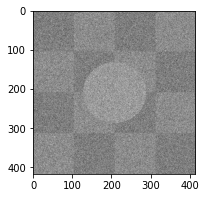

In [385]:
plt.imshow(x_noise, 'gray')

In [ ]:
idx = 0
ij = model.idx[idx]
print(f'label: {labels[ij]}')
print(f'delta: {model.deltas[idx]}')
print(f'new class: {model.new_classes[idx]}')
print(f'changed       : {model.changed[idx]}')
print(f'total changes : {int(x_changed[ij])}')

In [127]:
neighbors_indices = [[0,1],[0,-1],[1,0],[-1,0]]

In [1305]:
def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var =  cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    print(initial_energy)
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    print(initial_energy)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * differnce(w[i][j], w[a][b])
    print(initial_energy)
    new_energy = 0
    mean = cls_info[new_value][1]
    var =  cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    print(new_energy)
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
    print(new_energy)
    # print("/////// \n first enegry", new_energy)
    
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * differnce(new_value, w[a][b])
    print(new_energy)
    # print ("END energy", new_energy)
    return new_energy - initial_energy

In [429]:
import random

def simulated_annealing(init_w, 
                        class_labels,
                        temprature_function,
                        pixels,
                        betha,
                        cls_info,
                        neighbors_indices, 
                        max_iteration=10000,
                        initial_temp = 1000, 
                        known_index=[], 
                        correct_arr = [], 
                        temprature_function_constant=None ,
                       target=None):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True

    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =1
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function(w, pixels, betha, cls_info, neighbors_indices)
    print(f'current energy: {current_energy}')
    deltas = []
    idx = []
    new_classes = []
    energy = [current_energy]
    changed = []
    
    start_dt = time.time()
    current_tmp = initial_temp
    while (iteration<max_iteration):
        step_dt = time.time()
        if iteration % 500 == 0:
            elapsed_time = time.time() - start_dt
            template = f'step {iteration} - {int(elapsed_time)}s '
            template += f'{int(elapsed_time/iteration)}s/step - energy : {current_energy:.4f} '
            if target is not None:
                template += f'- acc : {np.mean(w == target):.4f}'
            print(template)
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)
        print(time.time() - step_dt)
        # sample a random incorrect class label
        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        new_classes.append(new_value)
        idx.append((i,j))
        print(time.time() - step_dt)
        delta = delta_enegry(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_info)
        print(time.time() - step_dt)
        deltas.append(delta)
        r = random.uniform(0, 1)

#         if (delta<=0):
#             w[i][j]=new_value
#             current_energy+=delta
#             changed_array[i][j]+=1
#             changed.append(1)
#             # print ("CHANGED better")
#         else:
#             try:
#                 if (delta / current_tmp > 600):
#                     k=0
#                 else:
#                     k = np.exp(-delta / current_tmp)
#             except:
#                 k=0

#             if r < k:
#                 # print("CHANGED worse")
#                 w[i][j] = new_value
#                 current_energy += delta
#                 changed_array[i][j] += 1
#                 changed.append(1)
#             else:
#                 changed.append(0)
        print(time.time() - step_dt)
        energy.append(current_energy)
        
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
        print(time.time() - step_dt)
        print(iteration)
    return w, changed_array, deltas, idx, new_classes, energy, changed

def convert_to_class_labels(arr, inverse_array={0:0, 127:1, 255:2}):
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            arr[i][j] = inverse_array[int(arr[i][j])]

def get_accuracy(arr, labels):
    correct = 0
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            if (labels[i][j]==int(arr[i][j]/127)):
                correct+=1
    return correct/(len(arr[0])*len(arr))

# plt.close('all')
def a_complete_set_for_part_1 (arr,
                               max_iter=1000000,
                               var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2], 
                               class_color = [0,127,255], 
                               initial_temp=1000,
                               schedule= exponential_schedule,
                               temprature_function_constant=None):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
    plt.subplots_adjust(wspace=1., hspace=0.3)
#     fig.suptitle('Comparision', fontsize=20)
    
    noisy_arr = add_noise(arr, var)
    ax1.set_title('Noisy image \n accuracy '+str(get_accuracy(noisy_arr, labels)))

    ax1.imshow(noisy_arr, cmap='gray')


    rows = len(noisy_arr)
    cols = len(noisy_arr[0])

    cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    initial_arr = naive_bayes_predict(noisy_arr, cls_info)
    ax2.set_title('Naive Bayes image \n accuracy '+str(get_accuracy(initial_arr, labels)))
    ax2.imshow(initial_arr, cmap='gray')

    convert_to_class_labels(initial_arr)
    lbl = arr.copy() * 255
    convert_to_class_labels(lbl)
    
    w, test_array, deltas, idx, new_classes, energy, changed = simulated_annealing(init_w=initial_arr, 
                                        class_labels=class_labels,
                                        temprature_function=schedule,
                                        pixels=noisy_arr,
                                        betha=betha, 
                                        cls_info=cls_info,
                                        neighbors_indices=neighbor_indices, 
                                        max_iteration=max_iter,
                                                                                  target=lbl)

    
    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image \n accuracy '+str(get_accuracy(w, labels)))
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)


    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

    plt.show()
    return deltas, idx, new_classes, energy, changed

current energy: 262826.7195514685


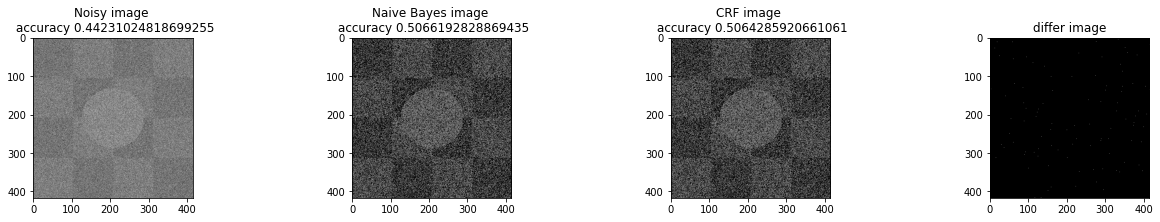

0:00:06.230550


In [162]:
start_dt = time.time()
deltas, idx, new_classes, energy, changed = a_complete_set_for_part_1(x_arr,
                                                                      max_iter=100,
                                                                      var=1,
                                                                      initial_temp=10,
                                                                      betha=1)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)

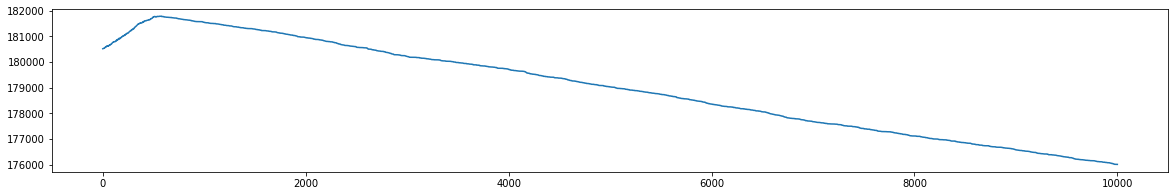

In [905]:
plt.plot(energy1)

current energy: 180520.71304593337


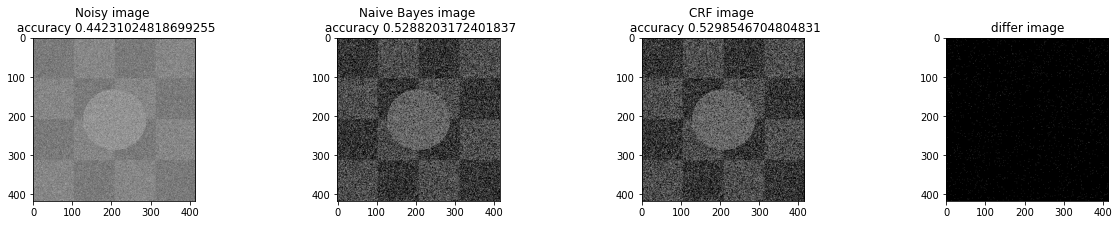

In [904]:
deltas1, idx1, new_classes1, energy1, changed1 = a_complete_set_for_part_1(x_arr,
                                                                      max_iter=1e4,
                                                                      var=1,
                                                                      initial_temp=10,
                                                                      betha=1)
# a_complete_set_for_part_1(x_arr, max_iter=1e4, var=1, betha=1, )

In [897]:
sum(model.changed)

95202

In [416]:
np.mean(changed)

0.045997045997045995

current energy: 179862.99532997844
2.09808349609375e-05
4.601478576660156e-05
8.845329284667969e-05
0.00010132789611816406
0.00011205673217773438
2
3.814697265625e-06
2.3126602172851562e-05
8.511543273925781e-05
0.00010156631469726562
0.00010991096496582031
3
4.5299530029296875e-06
2.6941299438476562e-05
0.00019240379333496094
0.0002124309539794922
0.0002219676971435547
4
4.291534423828125e-06
0.00011372566223144531
0.000156402587890625
0.0001735687255859375
0.0003542900085449219
5


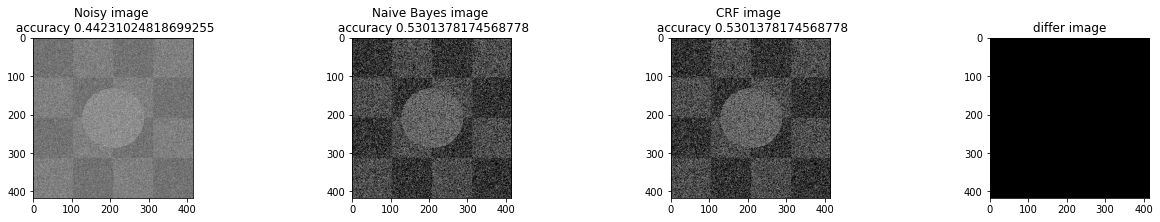

0:00:06.357621


In [435]:
start_dt = time.time()
deltas, idx, new_classes, energy, changed = a_complete_set_for_part_1(x_arr,
                                                                      max_iter=5,
                                                                      var=1,
                                                                      initial_temp=10,
                                                                      betha=1)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)
# a_complete_set_for_part_1(x_arr, max_iter=1e6, var=1., betha=1e2)

1.430511474609375e-06
0.0005033016204833984
0.0005691051483154297
0.000682830810546875
0.0007061958312988281
0.0007238388061523438
1
7.152557373046875e-07
0.00016808509826660156
0.00021004676818847656
0.0002713203430175781
0.00028824806213378906
0.0002994537353515625
2
4.76837158203125e-07
0.0002789497375488281
0.0003197193145751953
0.00038051605224609375
0.0003993511199951172
0.000652313232421875
3
4.76837158203125e-07
0.0003159046173095703
0.00035452842712402344
0.0004086494445800781
0.0005908012390136719
0.0006084442138671875
4
4.76837158203125e-07
0.0001995563507080078
0.0002377033233642578
0.00029349327087402344
0.0003113746643066406
0.0003254413604736328
5
0:00:00.666739


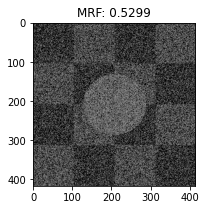

In [437]:
model2 = MRF(3, beta=1, start_temperature=1000., verbose=500, delta_th=-600, workers=8)
start_dt = time.time()
a,b = model2.fit(x_noise, labels, 5)
elapsed = datetime.timedelta(seconds=time.time() - start_dt)#.strftime('%H:%M:%S')
print(elapsed)
y_pred = np.vectorize(label_to_value.__getitem__)(a)
plt.imshow(y_pred/255., 'gray')
plt.title(f'MRF: {np.mean(y_pred == arr):.4f}')
plt.show();